# 김기범 데이터 시각화

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# 1. 대회에서 제공하는 Train 데이터셋

In [34]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv("../data/test.csv")

print("train shape >>", train_df.shape)
print("test shape >>", test_df.shape)

train shape >> (45678, 5)
test shape >> (9107, 4)


In [35]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45678 entries, 0 to 45677
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      45678 non-null  object
 1   text    45678 non-null  object
 2   target  45678 non-null  int64 
 3   url     45678 non-null  object
 4   date    45678 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [36]:
train_df.head()

,ID,text,target,url,date
0,ynat-v1_train_00000,유튜브 내달 2일까지 크리에이터 지원 공간 운영,3,https://news.naver.com/main/read.nhn?mode=LS2D...,2016.06.30. 오전 10:36
1,ynat-v1_train_00001,어버이날 막따가 흐려저…남부지방 여튼 황사,3,https://news.naver.com/main/read.nhn?mode=LS2D...,2016.05.08. 오전 5:25
2,ynat-v1_train_00002,내년부터 국가RD 평가 때 논문건수는 반영 않는다,2,https://news.naver.com/main/read.nhn?mode=LS2D...,2016.03.15. 오후 12:00
3,ynat-v1_train_00003,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것,2,https://news.naver.com/main/read.nhn?mode=LS2D...,2017.02.28. 오전 9:54
4,ynat-v1_train_00004,회새긴간 작까 김동시 걍심꼬백 뜽 새 소설집 뚜권 출간,3,https://news.naver.com/main/read.nhn?mode=LS2D...,2018.04.03. 오전 7:05


## 1.1 target 분포 보기

In [37]:
train_df['text'].value_counts()

text
유튜브 내달 2일까지 크리에이터 지원 공간 운영          1
조인근 연설비서관 사직…靑 공석 느는데 사람찾기 쉽지않네     1
에르도안 아메리카 원주민 인종청소 규정하겠다 美압박        1
중국 퀄컴 이어 에릭슨도 반독점 위반 조사             1
한컴시큐어 블록체인 분석 솔루션 사업…비트퓨리와 협약       1
                                   ..
올해 소규모 농어촌 마을 1천460곳에 광대역망 구축       1
대한상의 기업활력법 사업재편전략 세미나 17일 개최        1
KT도 무제한 데이터…워 륭만구처눠네 이령영GB 기본 제공    1
아베 총리 소비세 증세 2년반 연기…2차 추경도 검토       1
극적 역전승 도로공사 GS칼텍스 꺾고 2년 연속 챔프...    1
Name: count, Length: 45678, dtype: int64

<Axes: xlabel='target', ylabel='count'>

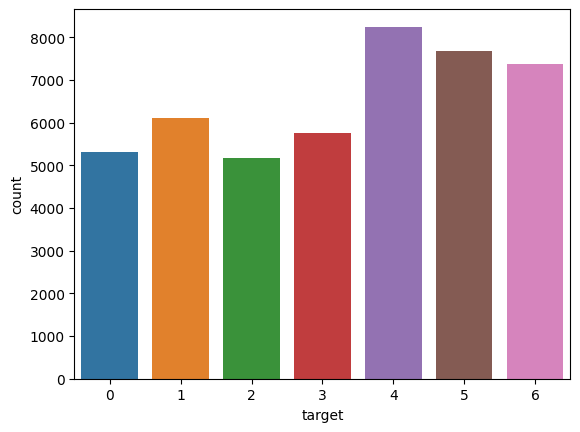

In [38]:
sns.countplot(data=train_df, x='target')

## 1.2 토큰화 진행 후 [PAD] 등장 위치

In [39]:
import gluonnlp as nlp

from kobert import get_tokenizer
from kobert import get_pytorch_kobert_model

In [40]:
### Load Tokenizer and Model ###
bertmodel, vocab = get_pytorch_kobert_model(cachedir=".cache")
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)
transform = nlp.data.BERTSentenceTransform(tok, max_seq_length=64, pad=True, pair=False)

using cached model. /opt/ml/data_analysis/.cache/kobert_v1.zip
using cached model. /opt/ml/data_analysis/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece
using cached model. /opt/ml/data_analysis/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [41]:
text_after_tokenizing = []

for input_text in train_df['text'].tolist():
    input_text_after_tokenizing.append(transform([input_text]))

len(text_after_tokenizing)

0

In [42]:
find_pad = []

for x in input_text_after_tokenizing:
    pad_idx = x[0].tolist().index(1)
    find_pad.append(pad_idx)

len(find_pad)

91356

Text(0, 0.5, 'count')

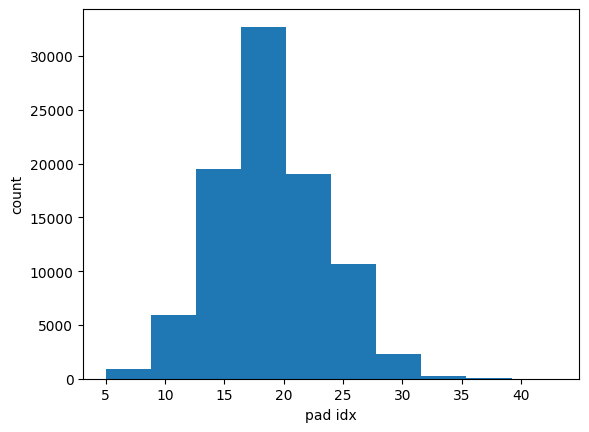

In [43]:
plt.hist(find_pad)
plt.xlabel('pad idx')
plt.ylabel('count')

## 1.3 Label Error 찾기

- annotation과 label_input이 다른 거 찾기

def logic(x):
    x.sort()
    
    return x[0] if x[0] == x[1] else x[1]

train_df['first-scope'] = train_df['annotations'].apply(lambda x: logic(eval(x)['annotations']['first-scope']))

view_df = train_df[train_df['text'] != train_df['first-scope']]

len(view_df)

train_df.shape, train_df.drop(view_df.index, axis=0).shape, 52530 - 1371

- annotaitons 안 쓰고 찾는 방법

train_df.drop_duplicates(inplace=True)

train_df.drop_duplicates(subset=['ID', 'text']).shape

train_df.duplicated(['ID', 'text'], keep=False).value_counts()

view_df = train_df[train_df.duplicated(['ID', 'text'], keep=False)]
view_df.shape

train_df.drop(view_df.index, axis=0).shape

print(view_df[view_df['text'] == view_df['predefined_news_category']].shape)
view_df[view_df['text'] == view_df['predefined_news_category']].head(10)

view_ID_list = view_df[view_df['text'] == view_df['predefined_news_category']]['ID'].values
len(view_ID_list)

view_df[view_df['ID'] == 'ynat-v1_train_00491']

## 1.4 한글 영어 외 다른 문자 찾기

### 1.4.1 자음 여부 확인

In [44]:
train_df['text'].str.extract('([ㄱ-ㅎㅏ-ㅣ]+)').value_counts()

Series([], Name: count, dtype: int64)

### 1.4.2 일본어 여부 확인

In [45]:
train_df['text'].str.extract('([ぁ-ゔァ-ヴー々〆〤]+)').value_counts()

Series([], Name: count, dtype: int64)

### 1.4.3 한자 여부 확인

In [46]:
train_df['text'].str.extract('([一-龥]+)').value_counts()

美     1432
北     1199
朴      703
中      683
日      416
      ... 
生生       1
說        1
論        1
史        1
氣        1
Name: count, Length: 139, dtype: int64

### 1.4.4 특수문자 확인

In [47]:
train_df['text'].str.extract('([^A-Za-z0-9가-힣\sぁ-ゔァ-ヴー々〆〤一-龥]{1,9999})').value_counts()

…        17138
·         4787
.          585
...        441
%          382
         ...  
○○○○…        1
♥            1
㎃            1
㎏·           1
ｍ…           1
Name: count, Length: 97, dtype: int64

In [48]:
print(transform(['…'])[0])
print(transform(['…女'])[0])
print(transform(['㎒'])[0])
print(transform(['㎏·'])[0])
print(transform(['♥'])[0])
print(transform(['꿿'])[0])

[  2 517  55   3   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1]
[   2  517   55  517 5265    3    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1]
[  2 671 294 459   3   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1]
[  2 517 417 517 478   3   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1  

# 2. AI HUB 뉴시 기사 기계독해 데이터

In [55]:
ai_hub_017 = pd.read_csv("../data/ai_hub_017.csv")

ai_hub_017.shape

(111998, 4)

In [56]:
ai_hub_017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111998 entries, 0 to 111997
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   ID          111998 non-null  object
 1   text        111998 non-null  object
 2   label_text  111998 non-null  object
 3   target      111998 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 3.4+ MB


## 2.1 target 분포 보기

<Axes: xlabel='target', ylabel='count'>

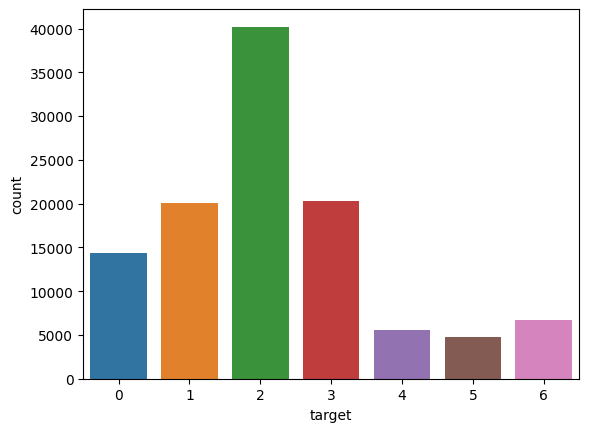

In [57]:
sns.countplot(data=ai_hub_017, x='target')

## 2.2 토크나이징 후에 [PAD] 등장 위치

In [58]:
input_text_after_tokenizing = []

for input_text in ai_hub_017['text'].tolist():
    input_text_after_tokenizing.append(transform([input_text]))

len(input_text_after_tokenizing)

111998

In [59]:
find_pad = []

for x in input_text_after_tokenizing:
    try:
        pad_idx = x[0].tolist().index(1)
    except:
        pad_idx = 64
    find_pad.append(pad_idx)

len(find_pad)

111998

Text(0, 0.5, 'count')

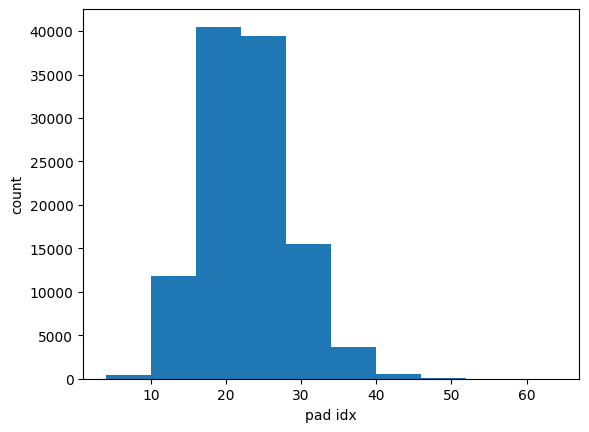

In [60]:
plt.hist(find_pad)
plt.xlabel('pad idx')
plt.ylabel('count')

## 2.3 한글 영어 외 다른 문자 찾기

### 2.3.1 자음 여부 확인

In [61]:
ai_hub_017['text'].str.extract('([ㄱ-ㅎㅏ-ㅣ]+)').value_counts()

ㅠㅠ       4
ㅋㅋ       2
ㄱ        1
ㅅ        1
ㅅㅁㄱㄷㄹ    1
ㅈㅂㅈㅇ     1
ㅡ        1
Name: count, dtype: int64

### 2.3.2 일본어 여부 확인

In [62]:
ai_hub_017['text'].str.extract('([ぁ-ゔァ-ヴー々〆〤]+)').value_counts()

Series([], Name: count, dtype: int64)

### 2.3.3 한자 여부 확인

In [63]:
ai_hub_017['text'].str.extract('([一-龥]+)').value_counts()

美       1558
日        745
文        731
中        550
與        437
        ... 
書風萬里       1
最古         1
木          1
村          1
黨心         1
Name: count, Length: 334, dtype: int64

### 2.3.4 특수문자 확인

In [64]:
ai_hub_017['text'].str.extract('([^A-Za-z0-9가-힣\sぁ-ゔァ-ヴー々〆〤一-龥]{1,9999})').value_counts()

,      35781
'      15473
[       9888
"       7659
‘       7496
       ...  
,·‘        1
,“‘        1
“’         1
-'         1
­          1
Name: count, Length: 246, dtype: int64

# 3. 낚시성 기사 탐지 데이터

In [65]:
ai_hub_146 = pd.read_csv("../data/ai_hub_146_val.csv")
ai_hub_146.shape

(111998, 4)

In [66]:
ai_hub_146.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111998 entries, 0 to 111997
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   ID          111998 non-null  object
 1   text        111998 non-null  object
 2   label_text  111998 non-null  object
 3   target      111998 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 3.4+ MB


## 3.1 target 분포

<Axes: xlabel='target', ylabel='count'>

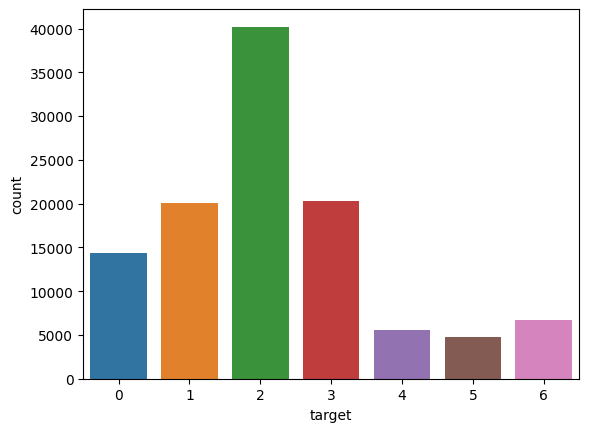

In [67]:
sns.countplot(data=ai_hub_146, x='target')

## 3.2 토크나이징 후에 [PAD] 등장 위치

In [68]:
input_text_after_tokenizing = []

for input_text in ai_hub_146['text'].tolist():
    input_text_after_tokenizing.append(transform([input_text]))

len(input_text_after_tokenizing)

111998

In [69]:
find_pad = []

for x in input_text_after_tokenizing:
    try:
        pad_idx = x[0].tolist().index(1)
    except:
        pad_idx = 64
    find_pad.append(pad_idx)

len(find_pad)

111998

Text(0, 0.5, 'count')

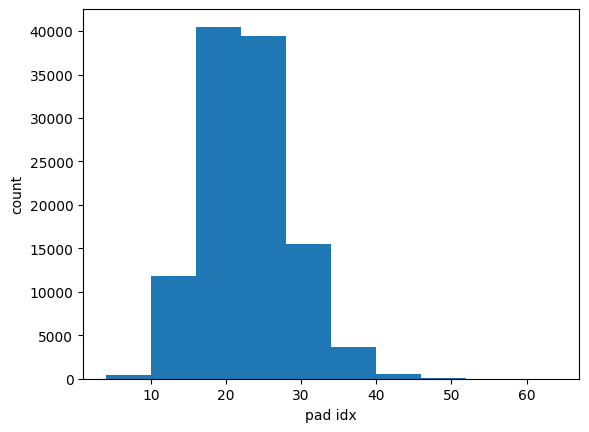

In [70]:
plt.hist(find_pad)
plt.xlabel('pad idx')
plt.ylabel('count')

## 3.3 한글 영어 외 다른 문자 찾기

### 3.3.1 자음 여부 확인

In [71]:
ai_hub_146['text'].str.extract('([ㄱ-ㅎㅏ-ㅣ]+)').value_counts()

ㅠㅠ       4
ㅋㅋ       2
ㄱ        1
ㅅ        1
ㅅㅁㄱㄷㄹ    1
ㅈㅂㅈㅇ     1
ㅡ        1
Name: count, dtype: int64

### 3.3.2 일본어 여부 확인

In [72]:
ai_hub_146['text'].str.extract('([ぁ-ゔァ-ヴー々〆〤]+)').value_counts()

Series([], Name: count, dtype: int64)

### 3.3.3 한자 여부 확인

In [73]:
ai_hub_146['text'].str.extract('([一-龥]+)').value_counts()

美       1558
日        745
文        731
中        550
與        437
        ... 
書風萬里       1
最古         1
木          1
村          1
黨心         1
Name: count, Length: 334, dtype: int64

### 3.3.4 특수문자 확인

In [74]:
ai_hub_146['text'].str.extract('([^A-Za-z0-9가-힣\sぁ-ゔァ-ヴー々〆〤一-龥]{1,9999})').value_counts()

,      35781
'      15473
[       9888
"       7659
‘       7496
       ...  
,·‘        1
,“‘        1
“’         1
-'         1
­          1
Name: count, Length: 246, dtype: int64

# 4. AI HUB 데이터끼리 비교

In [75]:
ai_hub_concat = pd.concat([ai_hub_017, ai_hub_146], axis=0)
ai_hub_concat.shape

(223996, 4)

In [76]:
ai_hub_concat.drop_duplicates(subset=['text', 'target']).shape, ai_hub_017.shape, ai_hub_146.shape

((110563, 4), (111998, 4), (111998, 4))

In [77]:
ai_hub = ai_hub_concat.drop_duplicates(subset=['text', 'target'])
new_data = pd.concat([train_df, ai_hub], axis=0)
new_data.shape

(156241, 6)

In [78]:
new_data.drop_duplicates(subset=['text', 'target']).shape, new_data.drop_duplicates(subset=['text']).shape

((156241, 6), (156212, 6))

<Axes: xlabel='target', ylabel='count'>

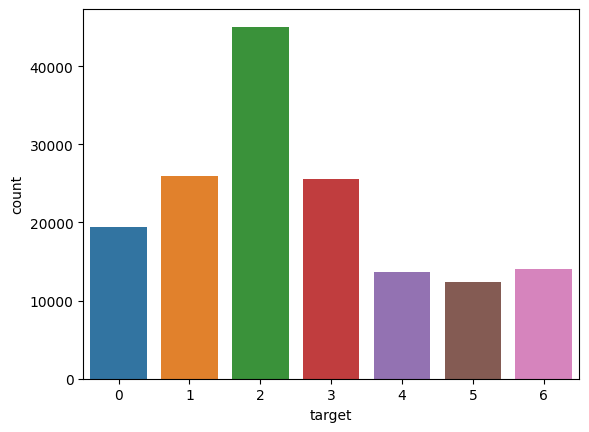

In [79]:
sns.countplot(data=new_data, x='target')

<Axes: xlabel='target', ylabel='count'>

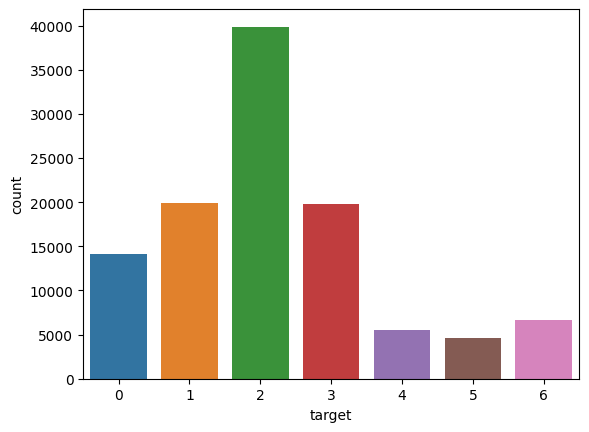

In [80]:
sns.countplot(data=ai_hub, x='target')

# 5. AI HUB 시각화

In [81]:
ai_hub = pd.read_csv('../data/ai_hub_original.csv')

ai_hub.shape

(110534, 4)

In [84]:
ai_hub[ai_hub['target'] == 0]['text'].head()

1         김경수 분노…“내가 문 대통령께 반발? 참 희한한 일”
8           기본주택 또 강조한 이재명…국회에서 관련 법도 발의
16    김정은, 해·공군 사령관 세대교체…‘젊은 피’로 친정체제 강화
22      김제동이 500만원 낸 정당은? 민주·정의 아닌 ‘미래당’
26           홍남기 “도시공원과 그린벨트 내 수소충전소 허용”
Name: text, dtype: object

In [85]:
ai_hub[ai_hub['target'] == 1]['text'].head()

4     작년 3분기 일자리 늘었다는데… 2030 일자리만 15만개 감소
5        327억원 흑자, 수신료 수입도 85억↑…부족하다는 KBS
17          MB 이후 11년 만에 다시 뜬 ‘광명·시흥 신도시’
19                  김정태 회장, 하나금융 1년 더 이끈다
20          부산항만공사·IBK기업은행, 상생펀드 140억원 조성
Name: text, dtype: object

In [86]:
ai_hub[ai_hub['target'] == 2]['text'].head()

3                 경남도, 신혼 반값 임대주택 공급 확대
7       ‘브레이크 고장’ 이삿짐 차 인도 돌진…60대 행인 부상
9            서울 유치원~초등 2학년 새 학기부터 매일 등교
12        “지난해 인구 순유입… 정착하고 싶은 도시 만들겠다”
15    지역 맞춤형 R&D 투자 전략 수립 미래 먹거리 발굴 나선다
Name: text, dtype: object

In [87]:
ai_hub[ai_hub['target'] == 3]['text'].head()

6         ‘엠카운트다운’ 선미, 역대급 퍼포먼스로 컴백 무대
10    넷플릭스 “한해 5500억원 투자, K콘텐츠 이미 세계적”
57    ‘맛남의 광장’ 레트로 백야 식당, 80년대 ‘청청 패션’
83        ‘뭉쳐야 쏜다’ 전설들의 각양각색 메인 포스터 공개
88      이경실, 성희롱 폭로 “속옷 보게 치마 벌리라던 선배”
Name: text, dtype: object

In [88]:
ai_hub[ai_hub['target'] == 4]['text'].head()

0     “시진핑엔 선물, 바이든엔 모욕”… 유럽의회서 막힌 中·EU투자협정
39                독일서 아스트라제네카 백신 85% 방치중…왜?
47        내리막길 질주하다 차량 수차례 굴러… 다리 중상 입고 대수술
49     화이자 백신, ‘실제 임상’서도 효력 90% 넘어…120만명 분석
60            가죽 파고든 폐밧줄…상처입고 바닷속 떠도는 호랑이상어
Name: text, dtype: object

In [89]:
ai_hub[ai_hub['target'] == 5]['text'].head()

2        오늘부터 사라진 네이버 ‘실검’…빈자리엔 날씨와 주가
11           대구시 965억원 투입해 ‘스마트시티’ 탈바꿈
14        LG전자 공기과학연구소, 업계 최초로 ‘국가 공인’
43    호주, 세계 최초로 구글·페이스북에 ‘뉴스 사용료’ 물린다
51     ‘턱스크’도 가려낸다…에스원, AI 발열감지 솔루션 출시
Name: text, dtype: object

In [90]:
ai_hub[ai_hub['target'] == 6]['text'].head()

13          박지수, 우승 놓쳤지만 독무대…MVP·최초 7관왕 달성
50         “내가 슈워버보다 못하다고?” 추신수, 한국행 결심 이유
69    “차 덕분에 살아”vs“차 때문에 다쳐”… GV80 놓고 갑론을박
78            “역시 류현진” 첫 라이브피칭 본 토론토 감독 반응
87             ‘虎’사다마… 타이거 우즈, 골프 인생 최대 위기
Name: text, dtype: object